# Water Availability Prediction

Thi dataset is from the [Water Point Data Organization](https://www.waterpointdata.org/)and was shared as part of data science challenge (Tidy Tuesday Challenge by R4DataScience)

Per [WPDX](https://www.waterpointdata.org/)

> The amount of water point data being collected is growing rapidly as governments and development partners increasingly monitor water points over time. Without harmonization among these different data sources, the opportunity for learning will be limited, with the true potential of this information remaining untapped. 

> By establishing a platform for sharing water point data throughout the global water sector, WPDx adds value to the data already being collected. By bringing together diverse data sets, the water sector can establish an unprecedented understanding of water services.

> Sharing this data has the potential to improve water access for millions of people as a result of better information available to governments, service providers, researchers, NGOs, and others.

The data for the challenge was confined to a few key columns and filtered largely to African countries. 

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import matplotlib.patches as mpatches
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,f1_score
import plotly.express as px
import geopandas
from matplotlib.lines import Line2D 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import joblib

%matplotlib inline

In [70]:
np.random.seed(110)

### Load Data

In [71]:
wtr=pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-05-04/water.csv')

### Exploratory Data Analysis & Data Cleaning

Each row is source of water :

In [72]:
wtr.head()

,row_id,lat_deg,lon_deg,report_date,status_id,water_source,water_tech,facility_type,country_name,install_year,installer,pay,status
0,3957,8.073136,38.617037,04/06/2017,y,NaN,NaN,NaN,Ethiopia,NaN,Private-CRS,NaN,NaN
1,33512,7.373784,40.503824,08/04/2020,y,Protected Spring,NaN,Improved,Ethiopia,2019.0,WaterAid,NaN,NaN
2,35125,0.773458,34.929509,03/18/2015,y,Protected Shallow Well,NaN,Improved,Kenya,NaN,NaN,NaN,NaN
3,37760,0.780576,34.963640,03/18/2015,y,Borehole,NaN,Improved,Kenya,NaN,NaN,NaN,NaN
4,38118,0.779266,34.971120,03/18/2015,y,Protected Shallow Well,NaN,Improved,Kenya,NaN,NaN,NaN,NaN


In [73]:
wtr.describe()

,row_id,lat_deg,lon_deg,install_year
count,473293.000000,473293.000000,473293.000000,339003.000000
mean,277392.271244,1.581829,16.870186,2002.472775
std,170322.431844,10.202556,19.136223,11.864804
min,1.000000,-88.996556,-140.739594,1900.000000
25%,131158.000000,-0.628585,-0.724249,1998.000000
50%,253676.000000,4.933805,29.388622,2006.000000
75%,427525.000000,8.420984,32.204302,2010.000000
max,577803.000000,85.000000,179.483383,2045.000000


In [74]:
wtr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473293 entries, 0 to 473292
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   row_id         473293 non-null  int64  
 1   lat_deg        473293 non-null  float64
 2   lon_deg        473293 non-null  float64
 3   report_date    473293 non-null  object 
 4   status_id      473293 non-null  object 
 5   water_source   410579 non-null  object 
 6   water_tech     290703 non-null  object 
 7   facility_type  410485 non-null  object 
 8   country_name   473283 non-null  object 
 9   install_year   339003 non-null  float64
 10  installer      115742 non-null  object 
 11  pay            258323 non-null  object 
 12  status         363298 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 46.9+ MB


### Defining the problem statement
The dependant variable *status_id* that has three levels:
* Y : yes water is available
* N : water is unavailable
* U : unknown

So with the data for known sources,i.e. status_id = 'Y' or 'N', we could build a model predict whether water is available or not.


In [75]:
wtr.status_id.unique()

array(['y', 'u', 'n'], dtype=object)

In [76]:
wtr.status_id.value_counts()

y    336463
n    105953
u     30877
Name: status_id, dtype: int64

- For this challenge, I'll exclude the unknown status_ids

In [77]:
df=wtr.loc[wtr['status_id']!='u',:]

### Plotting the water sources on a map
Plotting Spatial information coded by color
- The plot indicates some of the data is wrong, unclean and also includes data from outside Africa

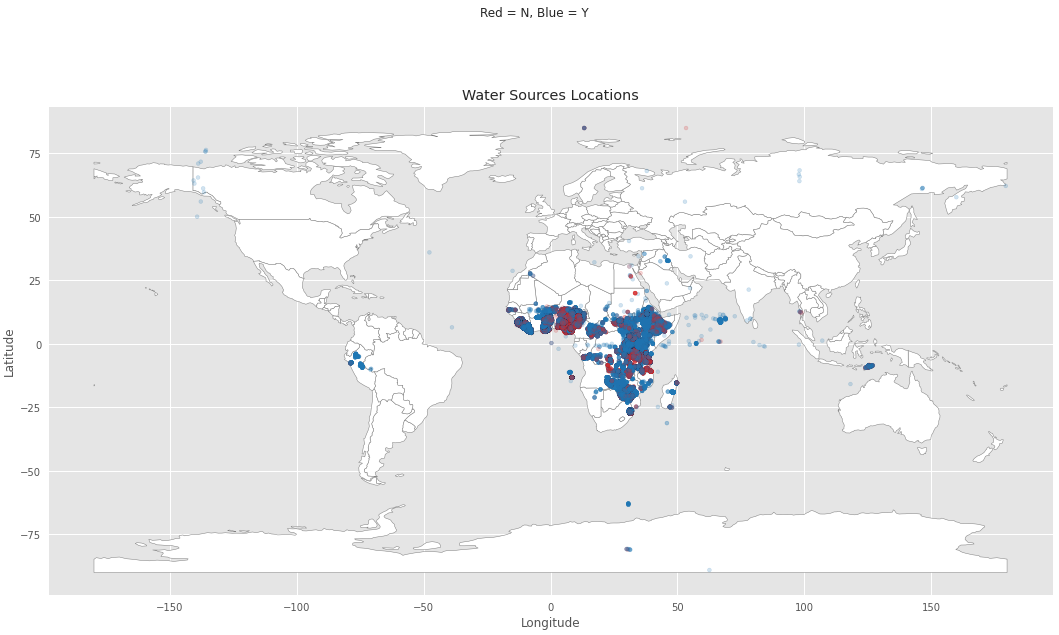

In [78]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
africa =  world[world.continent == "Africa"]
colors = {'y':'tab:blue', 'n':'tab:red'}
with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10),
               color="white",
               edgecolor = "grey");

    plt.scatter(df.lon_deg, df.lat_deg, s=15,c=df['status_id'].map(colors),alpha=0.2)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.suptitle('Red = N, Blue = Y')
    plt.title("Water Sources Locations");

### Count by Country

In [11]:
#filtering by country
wtr['country_name'].value_counts()

Uganda                      119671
Nigeria                      83703
Sierra Leone                 67706
Liberia                      33781
Ethiopia                     25917
Tanzania                     24923
Swaziland                    23913
Zimbabwe                     23695
Ghana                        21334
Kenya                        12153
Zambia                        9093
Congo - Kinshasa              7958
South Sudan                   6885
Rwanda                        2953
Mozambique                    2478
Central African Republic      2447
Niger                         1101
Burkina Faso                   820
Madagascar                     800
Mali                           648
Peru                           579
Timor-Leste                    400
Gambia                         149
Chad                            35
Sudan                           34
Congo - Brazzaville             29
Namibia                         21
South Africa                    15
Algeria             

### Restricting to Sierra Leone Only

In [12]:
df=df[(df['country_name']=='Sierra Leone') & (df['lat_deg']>0)&(df['lat_deg']<15)&(df['lon_deg']<0)]

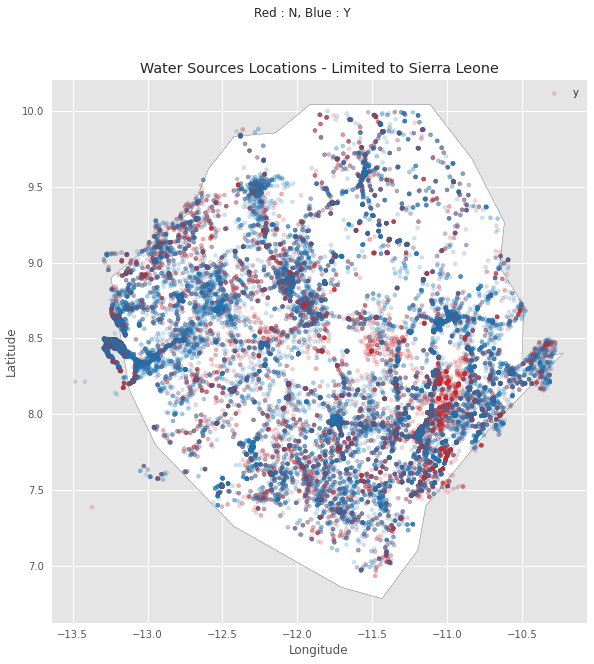

In [13]:
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
sl =  world[world.name == "Sierra Leone"]
colors = {'y':'tab:blue', 'n':'tab:red'}
with plt.style.context(("seaborn", "ggplot")):
    sl.plot(figsize=(18,10),
               color="white",
               edgecolor = "grey");

    plt.scatter(df.lon_deg, df.lat_deg, s=15,c=df['status_id'].map(colors),alpha=0.2, label=['n','y'])
    plt.legend(['y','n'],  loc = "upper right",facecolor='white', framealpha=1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.suptitle("Red : N, Blue : Y")
    plt.title("Water Sources Locations - Limited to Sierra Leone")
 
    
plt.show()
# sns.scatterplot(x='lon_deg',y='lat_deg',alpha=0.2,hue='status_id',data=df)

#### Dropping unused columns such as row_id, country name, status and report_date

In [14]:
water=df[df.columns[~df.columns.isin(['country_name','status','report_date','row_id'])]].copy()

#### Checking levels for payment, water tech,  facility type and install year

In [15]:
water['pay'].value_counts()

No- water is free                                   20020
No payment – its free                               17190
Only if there is a breakdown                         2561
No water                                             1806
Yes, Flat rate (LE/HH/month)                         1034
                                                    ...  
water has never supply                                  1
It is not free . people pay for it                      1
only after distribution system broke down in2012        1
point not used by community                             1
it was advised by expert to to drink                    1
Name: pay, Length: 62, dtype: int64

In [16]:
water['water_tech'].value_counts(normalize=True)

Hand Pump - India Mark     0.317369
Rope and Bucket            0.272651
Tapstand                   0.223129
Hand Pump - Kardia         0.079227
Hand Pump                  0.035554
Hand Pump - PB Mark II     0.018631
Hand Pump - Afridev        0.018370
Hand Pump - Inkar          0.012360
Kiosk                      0.010069
Mechanized Pump            0.008542
Hand Pump - Consallen      0.002050
Hydram                     0.001246
Hand Pump - Vergnet        0.000764
Mechanized Pump - Solar    0.000040
Name: water_tech, dtype: float64

In [17]:
water['facility_type'].value_counts()

Improved         29612
Unimproved        8506
No facilities      229
Unknown             90
Name: facility_type, dtype: int64

In [18]:
water['install_year'].value_counts()

2010.0    4090
2011.0    3975
2009.0    2930
2003.0    2926
2008.0    2711
          ... 
1943.0       2
1942.0       2
1932.0       2
1934.0       1
1931.0       1
Name: install_year, Length: 78, dtype: int64

In [19]:
water['installer'].value_counts()

Private Person     7350
Private            3325
Government         2779
Other              2646
Religious Group    2371
                   ... 
ifad                  1
ciuncil               1
bo pijuhun            1
Go-Bifo               1
mopada                1
Name: installer, Length: 2842, dtype: int64

In [20]:
water['water_source'].value_counts()

Protected Shallow Well                        22346
Unprotected Shallow Well                       8411
Borehole                                       4391
Piped Water                                    1773
Protected Spring                                589
Sand or Sub-surface Dam                         430
Surface Water (River/Stream/Lake/Pond/Dam)      229
Unprotected Spring                               95
Undefined Shallow Well                           86
Rainwater Harvesting                             83
Delivered Water                                  15
Undefined Spring                                  4
Name: water_source, dtype: int64

### Feature Engineering
Bundle less frequently occuring levels together


**Payment**
- If it stars with 'Yes' then pay is 'Yes'
- If it starts with 'No' then 'pay' is 'No'
- Else use value 'Its complicated'
- Nulls stays the same

In [21]:
water.loc[:,'pay']=np.where(water['pay'].str.startswith('No', na=False),'No',np.where(water['pay'].str.startswith('Yes', na=False),'Yes',np.where(water['pay'].isna(), np.nan,'its complicated')))

In [22]:
water['pay'].value_counts()

No                 39026
nan                 9808
its complicated     3091
Yes                 2868
Name: pay, dtype: int64

**Water technology**
- Multiple entries for handpump, collapse into one

In [23]:
### Multiple 'Hand Pump Entries'-- collapse to single
water.loc[water['water_tech'].str.startswith('Hand Pump', na=False),'water_tech']='Hand Pump'

### Water Source Availability over the years
Older water sources are less likely to have water available and newer ones are more likely to have it available

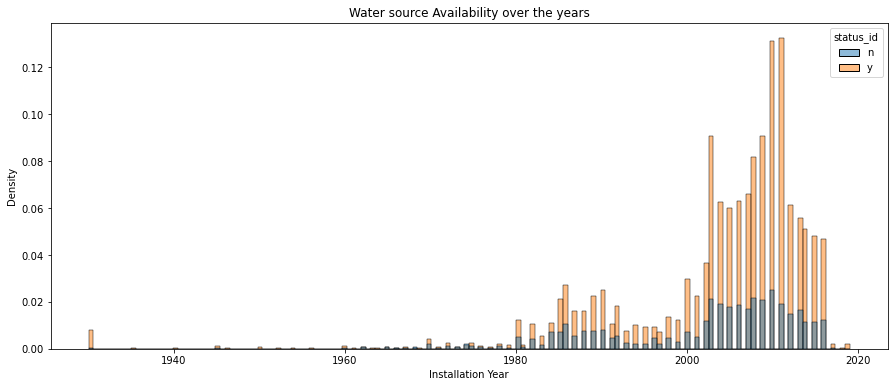

In [24]:
#histogram
plt.figure(figsize=(15,6))
sns.histplot(data= water, x='install_year',kde=False, stat="density", hue='status_id',alpha=0.5)
#plt.legend(title='Water Available?', prop={'size': 12})
plt.title('Water source Availability over the years')
plt.xlabel('Installation Year')
plt.ylabel('Density')
plt.show()
#px.histogram(water,x='install_year',color='status_id')

### Payment Types vs Water source availability
Seems like having a NA value for payment is associated with water not being available

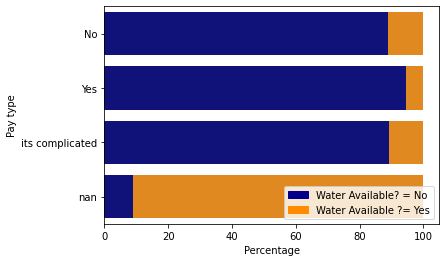

In [25]:
total=water.groupby('pay')['status_id'].count().reset_index()
wtr_y=water[water.status_id=='y'].groupby('pay')['status_id'].count().reset_index()
wtr_y['y_pct']=[i/j *100 for i,j in zip(wtr_y['status_id'],total['status_id'])]
total['y_pct']=[i/j *100 for i,j in zip(total['status_id'],total['status_id'])]

# bar chart 1 -> top bars (group of 'water=No')
bar1 = sns.barplot(y="pay",  x="y_pct", data=total, color='darkorange')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(y="pay", x="y_pct", data=wtr_y, color='darkblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='Water Available? = No')
bottom_bar = mpatches.Patch(color='darkorange', label='Water Available ?= Yes')
plt.legend(handles=[top_bar, bottom_bar])
plt.xlabel('Percentage')
plt.ylabel('Pay type')
# show the graph
plt.show()

## Model Creation

### Preprocessing

##### Divide into test (25%) and train (75%)

In [26]:
#stratified split by 'status_id' into training and testing
#X=water[water.columns[~water.columns.isin(['status_id'])]]#.values
X=water.copy()
y=water.loc[:,'status_id'].copy()#.values #.values converts to numpy ndarray needed for stratfied k fold
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)
X_test=X_test[X_test.columns[~X_test.columns.isin(['status_id'])]]

In [27]:
X_test.head()

,lat_deg,lon_deg,water_source,water_tech,facility_type,install_year,installer,pay
242339,7.955651,-11.748728,NaN,Rope and Bucket,NaN,2005.0,NaN,No
203637,8.493488,-13.284933,NaN,Tapstand,NaN,2012.0,Community,No
238498,9.501647,-12.249628,Protected Shallow Well,Hand Pump,Improved,2004.0,Government,No
252418,7.868882,-11.180433,NaN,Rope and Bucket,NaN,2008.0,NaN,No
384517,7.849224,-11.208895,Unprotected Shallow Well,Rope and Bucket,Unimproved,2009.0,Religious Group,No


In [28]:
X_train.status_id.value_counts()

y    30764
n    10330
Name: status_id, dtype: int64

##### Downsample prediction variable to handle class imbalance

In [29]:
#downsample
# Separate majority and minority classes
X_train_majority = X_train[X_train.status_id=='y']
X_train_minority = X_train[X_train.status_id=='n']
 
# Downsample majority class
X_train_majority_downsampled = resample(X_train_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=10330,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
X_train_downsampled = pd.concat([X_train_majority_downsampled, X_train_minority])
 
# Display new class counts
X_train_downsampled.status_id.value_counts()

n    10330
y    10330
Name: status_id, dtype: int64

In [30]:
X_train=X_train_downsampled.copy()
y_train=X_train.loc[:,'status_id']
X_train=X_train[X_train.columns[~X_train.columns.isin(['status_id'])]]
X_train.head()

,lat_deg,lon_deg,water_source,water_tech,facility_type,install_year,installer,pay
205576,8.428847,-13.273077,Piped Water,NaN,Improved,2010.0,Other,No
394618,7.967018,-11.723173,Unprotected Shallow Well,Rope and Bucket,Unimproved,2006.0,Private Person,No
246322,7.896486,-11.338102,Protected Shallow Well,Rope and Bucket,Improved,1985.0,Private,No
277742,7.709173,-11.010213,NaN,Tapstand,NaN,2010.0,GOAL,No
422693,8.486345,-13.238531,NaN,Kiosk,NaN,2010.0,School authorities,No


In [31]:
y_train.value_counts()

n    10330
y    10330
Name: status_id, dtype: int64

### Treating multiple levels and missing values

- Change NA levels to *'unknown'* for object datatypes

In [32]:
#fill NA by 'unknown' level for object dtypes , replace less frequent levels by 'other'
X_train.loc[:,X_train.select_dtypes(include = ["object"]).columns] = X_train.select_dtypes(include=['object']).apply(lambda x :x.fillna('unknown'))
#X_train.fillna('unknown')

In [33]:
X_train.loc[:,X_train.select_dtypes(include = ["object"]).columns]

,water_source,water_tech,facility_type,installer,pay
205576,Piped Water,unknown,Improved,Other,No
394618,Unprotected Shallow Well,Rope and Bucket,Unimproved,Private Person,No
246322,Protected Shallow Well,Rope and Bucket,Improved,Private,No
277742,unknown,Tapstand,unknown,GOAL,No
422693,unknown,Kiosk,unknown,School authorities,No
...,...,...,...,...,...
417012,Borehole,Hand Pump,Improved,Community,No
290141,unknown,unknown,unknown,Unknow,nan
285064,unknown,unknown,unknown,African Muslim Agency,nan
383741,unknown,Tapstand,unknown,IRC,No


- Change 'pay' nan to unknown

In [34]:
X_train.loc[X_train.pay=='nan','pay']='unknown'
X_train.loc[X_train.pay=='nan']

,lat_deg,lon_deg,water_source,water_tech,facility_type,install_year,installer,pay


*  For categories <3% assign 'other' factor level

In [35]:

X_train=X_train.apply(lambda x: x.mask(x.map(x.value_counts(normalize=True))<0.03, 'other') if x.dtype=='object' else x)
X_train['installer'].value_counts(normalize=True)

other                  0.430348
unknown                0.128074
Private Person         0.108325
Government             0.055324
Other                  0.051888
Private                0.050242
United Nations (UN)    0.039545
Religious Group        0.038819
Water Aid              0.034656
GVWC                   0.032285
Community              0.030494
Name: installer, dtype: float64

*  'Install_year' NA impute using linear model

In [36]:
X_train['install_year'].isna().sum()
X_train_num=X_train.select_dtypes(include=np.number)

In [37]:
# Regression imputation
imputer = IterativeImputer(BayesianRidge())
imputed_X_train_n = pd.DataFrame(imputer.fit_transform(X_train_num))
imputed_X_train_n.columns=X_train_num.columns
imputed_X_train_n['install_year'].isna().sum()

0

In [38]:
#join back to original dataset
X_train_new=X_train.reset_index(drop=True)
X_train_new=pd.concat([X_train_new,imputed_X_train_n[['install_year']]],axis=1)
X_train_new = X_train_new.dropna(axis='columns')
X_train_new.head()

,lat_deg,lon_deg,water_source,water_tech,facility_type,installer,pay,install_year
0,8.428847,-13.273077,Piped Water,unknown,Improved,Other,No,2010.0
1,7.967018,-11.723173,Unprotected Shallow Well,Rope and Bucket,Unimproved,Private Person,No,2006.0
2,7.896486,-11.338102,Protected Shallow Well,Rope and Bucket,Improved,Private,No,1985.0
3,7.709173,-11.010213,unknown,Tapstand,unknown,other,No,2010.0
4,8.486345,-13.238531,unknown,other,unknown,other,No,2010.0


In [39]:
X_train_new['water_source'].unique()

array(['Piped Water', 'Unprotected Shallow Well',
       'Protected Shallow Well', 'unknown', 'other', 'Borehole'],
      dtype=object)

In [40]:
X_train_new['water_tech'].unique()

array(['unknown', 'Rope and Bucket', 'Tapstand', 'other', 'Hand Pump'],
      dtype=object)

##### Dummy Encoding
To treat categorical data

In [41]:
X_train_new2=X_train_new.copy()
X_train_new2=pd.get_dummies(X_train_new2)

In [42]:
# water[water.pay=='nan']
X_train=X_train_new2.copy()
X_train_new2.isna().sum()


lat_deg                                  0
lon_deg                                  0
install_year                             0
water_source_Borehole                    0
water_source_Piped Water                 0
water_source_Protected Shallow Well      0
water_source_Unprotected Shallow Well    0
water_source_other                       0
water_source_unknown                     0
water_tech_Hand Pump                     0
water_tech_Rope and Bucket               0
water_tech_Tapstand                      0
water_tech_other                         0
water_tech_unknown                       0
facility_type_Improved                   0
facility_type_Unimproved                 0
facility_type_other                      0
facility_type_unknown                    0
installer_Community                      0
installer_GVWC                           0
installer_Government                     0
installer_Other                          0
installer_Private                        0
installer_P

In [43]:
X_train.head()

,lat_deg,lon_deg,install_year,water_source_Borehole,water_source_Piped Water,water_source_Protected Shallow Well,water_source_Unprotected Shallow Well,water_source_other,water_source_unknown,water_tech_Hand Pump,...,installer_Private Person,installer_Religious Group,installer_United Nations (UN),installer_Water Aid,installer_other,installer_unknown,pay_No,pay_Yes,pay_its complicated,pay_unknown
0,8.428847,-13.273077,2010.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,7.967018,-11.723173,2006.0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,7.896486,-11.338102,1985.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,7.709173,-11.010213,2010.0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
4,8.486345,-13.238531,2010.0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0


##### Match indexing of y to x

In [44]:
y_train.reset_index(drop=True, inplace=True)

### Test Dataset Processing 

Applying preprocessing on test data : Imputation, fixing multiple levels etc.

In [45]:
#prep test data
X_test.loc[:,X_test.select_dtypes(include = ["object"]).columns] = X_test.select_dtypes(include=['object']).apply(lambda x :x.fillna('unknown'))
X_test.loc[:,X_test.select_dtypes(include = ["object"]).columns]

,water_source,water_tech,facility_type,installer,pay
242339,unknown,Rope and Bucket,unknown,unknown,No
203637,unknown,Tapstand,unknown,Community,No
238498,Protected Shallow Well,Hand Pump,Improved,Government,No
252418,unknown,Rope and Bucket,unknown,unknown,No
384517,Unprotected Shallow Well,Rope and Bucket,Unimproved,Religious Group,No
...,...,...,...,...,...
208637,Piped Water,unknown,Improved,Private,No
411054,unknown,Kiosk,unknown,SALWACO,nan
236236,unknown,Rope and Bucket,unknown,unknown,No
395893,Unprotected Shallow Well,Rope and Bucket,Unimproved,Private Person,No


In [46]:
#change pay nan to unknown
X_test.loc[X_test.pay=='nan','pay']='unknown'
X_test.loc[X_test.pay=='nan']

,lat_deg,lon_deg,water_source,water_tech,facility_type,install_year,installer,pay


In [47]:
X_test=X_test.apply(lambda x: x.mask(x.map(x.value_counts(normalize=True))<0.03, 'other') if x.dtype=='object' else x)
X_test['installer'].value_counts(normalize=True)

other                  0.404555
Private Person         0.133659
unknown                0.123002
Private                0.059566
Government             0.053435
Other                  0.048617
Religious Group        0.044091
United Nations (UN)    0.039711
Community              0.032411
Water Aid              0.030951
GVWC                   0.030002
Name: installer, dtype: float64

In [48]:
X_test['install_year'].isna().sum()

1742

In [49]:
# Regression imputation
X_test['install_year'].isna().sum()
X_test_num=X_test.select_dtypes(include=np.number)
imputer = IterativeImputer(BayesianRidge())
imputed_X_test_n = pd.DataFrame(imputer.fit_transform(X_test_num))
imputed_X_test_n.columns=X_test_num.columns
imputed_X_test_n['install_year'].isna().sum()

0

In [50]:
#join back to original dataset
X_test_new=X_test.reset_index(drop=True)
X_test_new=pd.concat([X_test_new,imputed_X_test_n[['install_year']]],axis=1)
X_test_new = X_test_new.dropna(axis='columns')
X_test_new.head()

,lat_deg,lon_deg,water_source,water_tech,facility_type,installer,pay,install_year
0,7.955651,-11.748728,unknown,Rope and Bucket,unknown,unknown,No,2005.0
1,8.493488,-13.284933,unknown,Tapstand,unknown,Community,No,2012.0
2,9.501647,-12.249628,Protected Shallow Well,Hand Pump,Improved,Government,No,2004.0
3,7.868882,-11.180433,unknown,Rope and Bucket,unknown,unknown,No,2008.0
4,7.849224,-11.208895,Unprotected Shallow Well,Rope and Bucket,Unimproved,Religious Group,No,2009.0


In [51]:
X_test_new['water_source'].unique()

array(['unknown', 'Protected Shallow Well', 'Unprotected Shallow Well',
       'other', 'Borehole', 'Piped Water'], dtype=object)

In [52]:
X_test_new['water_tech'].unique()

array(['Rope and Bucket', 'Tapstand', 'Hand Pump', 'unknown', 'other'],
      dtype=object)

In [53]:
X_test_new2=X_test_new.copy()
X_test_new2=pd.get_dummies(X_test_new2)
X_test=X_test_new2.copy()
X_test_new2.isna().sum()

lat_deg                                  0
lon_deg                                  0
install_year                             0
water_source_Borehole                    0
water_source_Piped Water                 0
water_source_Protected Shallow Well      0
water_source_Unprotected Shallow Well    0
water_source_other                       0
water_source_unknown                     0
water_tech_Hand Pump                     0
water_tech_Rope and Bucket               0
water_tech_Tapstand                      0
water_tech_other                         0
water_tech_unknown                       0
facility_type_Improved                   0
facility_type_Unimproved                 0
facility_type_other                      0
facility_type_unknown                    0
installer_Community                      0
installer_GVWC                           0
installer_Government                     0
installer_Other                          0
installer_Private                        0
installer_P

In [54]:
y_test.reset_index(drop=True, inplace=True)

##### Specify a list of models

In [57]:
model_params= {
     'lgb' : {
        'model': LGBMClassifier(random_state=8072),
        'params' :{
            'lgb__n_estimators': [50, 100,150],
            'lgb__max_depth':[2,3,5],
            'lgb__learning_rate':[0.1,1,10],
            
        }
    },
    'rf' : {
        'model': RandomForestClassifier(random_state=8072),
        'params' :{
            'rf__n_estimators': [50,100,150],
            'rf__criterion': ['gini', 'entropy']
        }
    },
    'lr' :{
        'model' : LogisticRegression(random_state=8072),
        'params':{
             'lr__penalty': ['none', 'l2'],
             'lr__max_iter':[100,150]
        }
    },
    'knn':{
         'model' : KNeighborsClassifier(),
        'params':{
             'knn__n_neighbors': [1,3,5,7],
             'knn__metric':['euclidean','haversine']
        }
    }
}


### Validation methods

In [58]:
def print_report(clf,y_true_test,y_pred_test,model_name):
    class_names=[str(x) for x in clf.classes_]
    print('****************************************')
    print('Model Performance: '+model_name)
    print('****************************************')
    print(classification_report(y_true_test,y_pred_test,target_names=class_names))

In [59]:
def make_confusion_matrix(cf_matrix,model_name):
    group_names=['TN','FP','FN','TP']
    group_counts=['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_pct=['{0:0.0f}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels=[f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(group_names,group_counts,group_pct)]
    labels=np.asarray(labels).reshape(2,2)
    print('Model: '+model_name)
    plt.figure()
    sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Blues')
    plt.figure()

In [60]:
def roc_auc_curve(yactual,y_probs,modelname):
    ns_probs = [0 for _ in range(len(yactual))]
    ns_auc = roc_auc_score(yactual, ns_probs)
    mdl_auc = roc_auc_score(yactual, y_probs)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(f'{modelname}: ROC AUC=%.3f' % (mdl_auc))
    ns_fpr, ns_tpr, _ = roc_curve(yactual, ns_probs,pos_label='y')
    mdl_fpr, mdl_tpr, _ = roc_curve(yactual, y_probs,pos_label='y')
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(mdl_fpr, mdl_tpr, marker='.', label=f'{modelname}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

### Cross Validation
- 10 fold cv on Train, evaluation on test
- Using f1 macro as the evaluation metric - treating both classes equally
    - Want the model to be able to find more sources of water, so that we could use the resource for development activities.
    - Also want to have a high precision to reduce the cost of FP, as resources would be used to dig up water sources.


Test Perf: ***********
Model: lgb
****************************************
Model Performance: lgb
****************************************
              precision    recall  f1-score   support

           n       0.77      0.80      0.78      3443
           y       0.93      0.92      0.92     10256

    accuracy                           0.89     13699
   macro avg       0.85      0.86      0.85     13699
weighted avg       0.89      0.89      0.89     13699



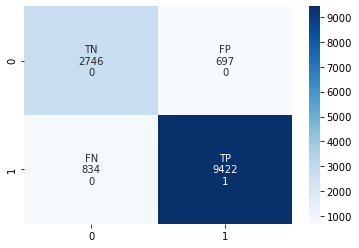

<Figure size 432x288 with 0 Axes>

Test Perf: ***********
Model: rf
****************************************
Model Performance: rf
****************************************
              precision    recall  f1-score   support

           n       0.71      0.84      0.77      3443
           y       0.94      0.89      0.91     10256

    accuracy                           0.88     13699
   macro avg       0.83      0.86      0.84     13699
weighted avg       0.89      0.88      0.88     13699



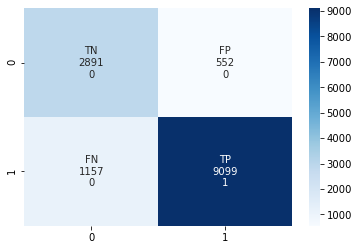

<Figure size 432x288 with 0 Axes>

Test Perf: ***********
Model: lr
****************************************
Model Performance: lr
****************************************
              precision    recall  f1-score   support

           n       0.78      0.72      0.75      3443
           y       0.91      0.93      0.92     10256

    accuracy                           0.88     13699
   macro avg       0.85      0.83      0.84     13699
weighted avg       0.88      0.88      0.88     13699



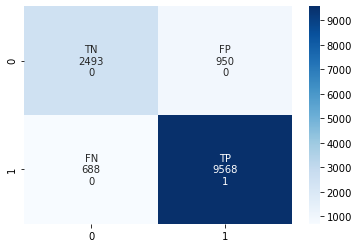

<Figure size 432x288 with 0 Axes>

Test Perf: ***********
Model: knn
****************************************
Model Performance: knn
****************************************
              precision    recall  f1-score   support

           n       0.69      0.82      0.75      3443
           y       0.94      0.87      0.90     10256

    accuracy                           0.86     13699
   macro avg       0.81      0.85      0.83     13699
weighted avg       0.87      0.86      0.87     13699



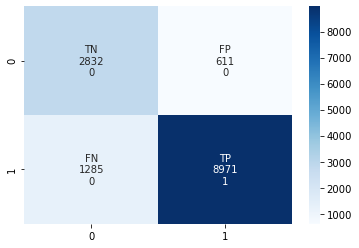

<Figure size 432x288 with 0 Axes>

In [61]:
# define the model
cv_score=[]
scoring={'f1_macro':'f1_macro'}
skf=StratifiedKFold(n_splits=10,shuffle=False)
for model_name,mp in model_params.items():
    cv=skf.split(X_train,y_train)
    pipe = Pipeline(steps=[('standardscaler', StandardScaler()),(model_name,mp['model'])])
    clf=GridSearchCV(pipe,mp['params'],cv=cv,n_jobs=-1,scoring='f1_macro',return_train_score=False,refit=True,verbose=False)
    clf.fit(X_train,y_train)
    cv_score.append({
        'model':model_name,
        'best_score':clf.best_estimator_.score(X_test,y_test),
        'best_params':clf.best_params_
    })
    print('Test Perf: ***********')
    y_true_test,y_pred_test=y_test,clf.best_estimator_.predict(X_test)
    cm=confusion_matrix(y_true_test,y_pred_test)
    make_confusion_matrix(cm,model_name)
    print_report(clf,y_true_test,y_pred_test,model_name)
    plt.show()

### Explore CV results

LGBMClassifier has the best F1 score , hence choosing it as the final model

In [62]:
cv_score

[{'model': 'lgb',
  'best_score': 0.888240017519527,
  'best_params': {'lgb__learning_rate': 0.1,
   'lgb__max_depth': 5,
   'lgb__n_estimators': 150}},
 {'model': 'rf',
  'best_score': 0.8752463683480546,
  'best_params': {'rf__criterion': 'entropy', 'rf__n_estimators': 100}},
 {'model': 'lr',
  'best_score': 0.8804292284108329,
  'best_params': {'lr__max_iter': 100, 'lr__penalty': 'none'}},
 {'model': 'knn',
  'best_score': 0.8615957369151033,
  'best_params': {'knn__metric': 'euclidean', 'knn__n_neighbors': 5}}]

Model: Light GBM Classifier


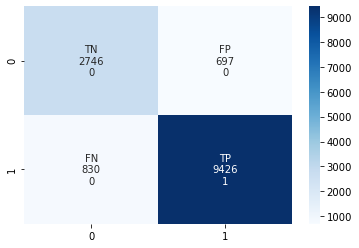

<Figure size 432x288 with 0 Axes>

In [63]:
model = LGBMClassifier(n_estimators=150,max_depth=5,random_state=8072)
model_name='Light GBM Classifier'
model.fit(X_train,y_train)
y_pred_test=model.predict(X_test)
cfm=confusion_matrix(y_test,y_pred_test)
make_confusion_matrix(cfm,model_name)

In [65]:
print_report(model,y_test,y_pred_test,model_name)

****************************************
Model Performance: Light GBM Classifier
****************************************
              precision    recall  f1-score   support

           n       0.77      0.80      0.78      3443
           y       0.93      0.92      0.93     10256

    accuracy                           0.89     13699
   macro avg       0.85      0.86      0.85     13699
weighted avg       0.89      0.89      0.89     13699



### ROC Curve

ROC AUC Curve
No Skill: ROC AUC=0.500
Light GBM Classifier: ROC AUC=0.947


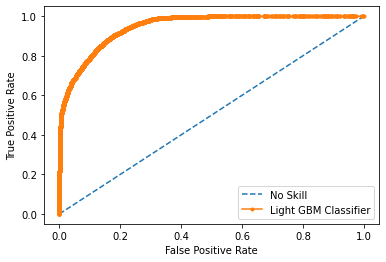

In [66]:
print("ROC AUC Curve")
y_probs=model.predict_proba(X_test)[:, 1]
roc_auc_curve(y_test,y_probs,model_name)

### Feature Importance

Identify what features help predict whether a water source is present or not

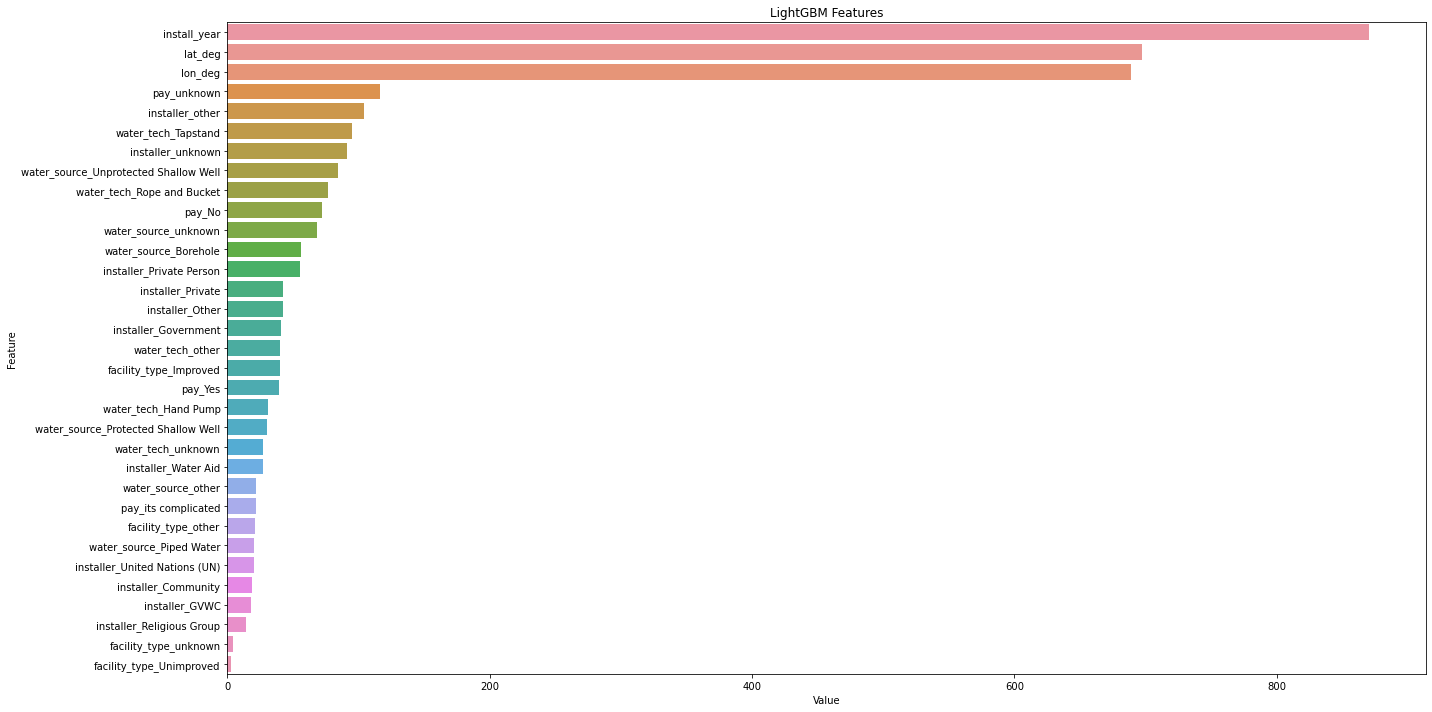

<Figure size 432x288 with 0 Axes>

In [67]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

### Save model

In [79]:
filename = f'{model_name}_finalized_model.sav'
joblib.dump(model, filename)

['Light GBM Classifier_finalized_model.sav']